In [1]:
!echo Installing bbSearch module from web ...
!echo creating bbmodcache subfolder
!mkdir -p bbmodcache
!echo downloading bbSearch module
!curl http://bb-ai.net.s3.amazonaws.com/bb-python-modules/bbSearch.py > bbmodcache/bbSearch.py

from bbmodcache.bbSearch import SearchProblem, search

Installing bbSearch module from web ...
creating bbmodcache subfolder
downloading bbSearch module
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18767  100 18767    0     0  67007      0 --:--:-- --:--:-- --:--:-- 67265
Loading bbSearch Version 2.1 (at 00:49, Thu 22 Feb)
Last module source code edit 9am Thursday 24th Feb 2022


In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from copy import deepcopy

plt.ioff()  ## Turn off immediate display of plots

COLORS = [ "darkgreen" ,"green", "limegreen", "yellowgreen", 
         "yellow", "gold", "orange", "orangered", "red"]

class BlockState:

      # Specify mapping from directions to grid coordinate offsets:
      neighbour_offset = {"left": (0,-1), "right": (0,+1), "down":(+1,0), "up":(-1,0)}

      def __init__( self, blockstate, colors=COLORS ):
        self.blockstate = blockstate
        self.nrows = len(blockstate)
        self.ncols = len(blockstate[0])
        self.blocknums = set().union(*[set(row) for row in blockstate])
        self.blocknums = self.blocknums - {0}
        self.blocknumlist = list(self.blocknums)
        self.colors = colors

      def __repr__(self):
        return( str( self.blockstate ))

      # Find the cells occupied by a given number
      def blockcells( self, blocknum ):
          blockcells = []
          for row in range(self.nrows):
            for col in range(self.ncols):
              if self.blockstate[row][col] == blocknum:
                blockcells.append((row,col))
          return blockcells

      # Test if a cell is free (unblocked) in a given direction
      # Free if not blocked by edge of grid or by a cell of different colour
      def free_cell( self, direction, cell ):
        row, col = cell
        offrow, offcol = BlockState.neighbour_offset[direction]
        neighrow, neighcol = (row + offrow, col + offcol)
        if not (0 <= neighrow < self.nrows): return False #at top or bottom
        if not (0 <= neighcol < self.ncols): return False #at left or right
        neighval = self.blockstate[neighrow][neighcol]
        # Neighboring cell must be empty or part of the same coloured block
        return  (neighval==0 or neighval==self.blockstate[row][col])

      def free_block( self, direction, blockn ):
          blockcells = self.blockcells(blockn)
          for cell in blockcells:
            if not self.free_cell(direction, cell):
              return False
          return True

      def possible_moves(self):
        moves = []
        for blocknum in self.blocknumlist:
          for direction in ["left", "right", "down", "up"]:
              if self.free_block(direction, blocknum):
                  moves.append((blocknum, direction))
        return moves

      def next_state(self, move):
          next_blockstate = deepcopy(self.blockstate)
          blockno, direction = move
          cells = self.blockcells(blockno)
          ## first clear all cells of the block (set to 0)
          for cell in cells:
            row, col = cell
            next_blockstate[row][col] = 0
          rowoff, coloff = BlockState.neighbour_offset[direction]
          ## now set all neighbour cells (in move direction) to be
          ## cells with the blocknumber
          for cell in cells:
            row, col = cell
            next_blockstate[row+rowoff][col+coloff] = blockno
          return BlockState(next_blockstate)

      def color_key(self):
          return {b:self.colors[b] for b in self.blocknumlist}

      def figure(self, scale=0.5):
          nrows = self.nrows
          ncols = self.ncols
          fig, ax = plt.subplots(figsize=(ncols*scale+0.1,nrows*scale+0.1))
          plt.close(fig)
          ax.set_axis_off() # Don't show border lines and coordinate values

          frame = patches.Rectangle((0,0),1,1, linewidth=5, edgecolor='k', facecolor='w')
          ax.add_patch(frame)

          for row in range(nrows):
            for col in range(ncols):
                greyrect = patches.Rectangle( (((col*0.9)/ncols)+0.05,
                                               (((nrows-row-1)*0.9)/nrows)+0.05 ),
                                            0.9/ncols, 0.9/nrows,
                                            linewidth=1, edgecolor="gray", facecolor="lightgray")
                ax.add_patch(greyrect)

          for row in range(nrows):
            for col in range(ncols):
                cellval = self.blockstate[row][col]
                if cellval > 0:
                  cellcol = COLORS[cellval]
                  rect = patches.Rectangle( (((col*0.9)/ncols)+0.05,
                                             (((nrows-row-1)*0.9)/nrows)+0.05 ),
                                            0.9/ncols, 0.9/nrows,
                                            linewidth=0, edgecolor=cellcol, facecolor=cellcol)
                  ax.add_patch(rect)
          return fig

      def display(self):
          display(self.figure())
        
      def goal_position(self, block_num):
        """
        Find the goal position (row, column) for a specific block number.
        """
        for row in range(self.nrows):
            for col in range(self.ncols):
                if self.goal.blockstate[row][col] == block_num:
                    return row, col

In [3]:
from copy import deepcopy


global_goal_state = None

class SlidingBlocksPuzzle( SearchProblem ):
    
    def __init__( self, initial_state, goal, colors=COLORS ):
        """
        The __init__ method must set the initial state for the search.
        Arguments could be added to __init__ and used to configure the
        initial state and/or other aspects of a problem instance.
        """
        self.initial_state = BlockState(initial_state, colors=colors)
        self.colors = colors
        self.goal = BlockState(goal)
        global global_goal_state
        global_goal_state = goal

    def info(self):
        print("Solve the following sliding blocks problem.")
        print("Get from this initial state:")
        self.initial_state.display()
        print("To a state incorporating the following block position(s):")
        self.goal.display()

    def possible_actions(self, state):
        return state.possible_moves()

    def successor(self, state, action):
        """
        This takes a state and an action and returns the new state resulting
        from doing that action in that state. You can assume that the given
        action is in the list of 'possible_actions' for that state.
        """
        return state.next_state(action)

    def goal_test(self, state):
        """
        For the sliding blocks puzzles, the goal condition is reached when
        all block possitions specified in the given goal state are satisfied by
        the current state. But empty positions (ie 0s) in the goal are ignored,
        so can be occupied by blocks in the current sate.
        """
        for row in range(state.nrows):
          for col in range(state.ncols):
            goalnum = self.goal.blockstate[row][col]
            if goalnum==0:
              continue
            if goalnum != state.blockstate[row][col]:
              return False
        return True


    def weighted_cost(self, path, state):
        """
        This is an optional method that you only need to define if you are using
        a cost based algorithm such as "uniform cost" or "A*". It should return
        the cost of reaching a given state via a given path.
        If this is not re-defined, it will is assumed that each action costs one unit
        of effort to perform, so it returns the length of the path.
        """
        total_cost = 0
        for move in path:
            
            blocknum, direction = move
            
            if(blocknum == 1):
                total_cost += blocknum 
            elif(blocknum == 2):
                total_cost += blocknum
            elif(blocknum == 3):
                total_cost += blocknum
            elif(blocknum == 4):
                total_cost += blocknum
            elif(blocknum == 5):
                total_cost += blocknum
            elif(blocknum == 6):
                total_cost += blocknum
            elif(blocknum == 7):
                total_cost += blocknum
            elif(blocknum == 8):
                total_cost += blocknum
            else:
                total_cost += blocknum
                
        return total_cost
    
    
    def move_cost(self, path, state):
        num_moves = len(path)
        total_cost = num_moves ** 2
        return total_cost



    def display_action(self, action):
        """
        You can set the way an action will be displayed in outputs.
        """
        print((self.colors[action[0]], action[1]))

    def display_state(self, state):
        """
        You can set the way a state will be displayed in outputs.
        """
        state.display()

    def display_state_path( self, actions ):
        """
        This defines output of a solution path when a list of actions
        is applied to the initial state. It assumes it is a valid path
        with all actions being possible in the preceeding state.
        You probably don't need to override this.
        """
        s = self.initial_state
        self.display_state(s)
        for a in actions:
            self.display_action(a)
            s = self.successor(s,a)
            self.display_state(s)
            
                    


In [4]:
#  puzzle scenarios


# aroundRed puzzle uses the weighted cost function to show how using a cost can affect the path

traverse_red_puzzle_initial = [[1, 0, 0, 0],
                               [8, 8, 8, 0],
                               [0, 0, 0, 0],
                               [0, 0, 0, 0]]

traverse_red_puzzle_goal = [[0, 0, 0, 0],
                            [0, 0, 0, 0],
                            [0, 0, 0, 0],
                            [1, 0, 0, 0]]

traverse_red_puzzle =  SlidingBlocksPuzzle( traverse_red_puzzle_initial, traverse_red_puzzle_goal )



# more general fair puzzle to compare effectiveness of search algorithms 

normal_puzzle_initial = [[8, 1, 0, 0],
                         [1, 1, 0, 0],
                         [6, 3, 3, 3],
                         [6, 0, 0, 0]]

normal_puzzle_goal = [[6, 0, 0, 0],
                      [6, 1, 0, 0],
                      [1, 1, 0, 0],
                      [3, 3, 3, 8]]

normal_puzzle =  SlidingBlocksPuzzle( normal_puzzle_initial, normal_puzzle_goal )


# not complete yet

four_corners_puzzle_initial = [[3, 0, 5, 5, 4, 4],
                               [0, 0, 0, 8, 4, 4],
                               [0, 0, 0, 8, 8, 0],
                               [0, 6, 6, 0, 0, 0],
                               [2, 2, 0, 0, 0, 0],
                               [2, 2, 0, 0, 0, 1]]

four_corners_puzzle_goal = [[1, 0, 0, 0, 2, 2],
                            [0, 0, 0, 0, 2, 2],
                            [0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0],
                            [4, 4, 0, 0, 0, 0],
                            [4, 4, 0, 0, 0, 3]]
                   
four_corners_puzzle =  SlidingBlocksPuzzle( four_corners_puzzle_initial, four_corners_puzzle_goal )


In [5]:
# heuristics   
        
# not rlly working yet     
def correct_positions_heuristic(state):
    
    incorrect_positions = 0
    for row in range(state.nrows):
        for col in range(state.ncols):
            if state.blockstate[row][col] != global_goal_state[row][col]:
                incorrect_positions += 1
    return incorrect_positions

def top_left_heuristic(state):
      for r, row in enumerate(state.blockstate):
        for c, col in enumerate(row):
          if col == 1:
            return r+c
        
        
def bottom_right_heuristic(state):
    for row in state.blockstate:
      for i, col in enumerate(row):
          if col == 3:
            return 6-i
        
        
        
def bottom_left_heuristic(state):
    max_distance = state.nrows + state.ncols - 2  # Maximum possible distance from bottom left corner
    for r, row in enumerate(state.blockstate):
        for c, col in enumerate(row):
            if col == 4:
                return max_distance - (r + (state.ncols - 1 - c))
    return max_distance  # If no block 1 is found, return maximum distance


def top_right_heuristic(state):
    max_distance = state.nrows + state.ncols - 2  # Maximum possible distance from top right corner
    for r, row in enumerate(state.blockstate):
        for c, col in enumerate(row):
            if col == 2:
                return max_distance - (state.nrows - 1 - r + c)
            
            
    return max_distance  # If no block 3 is found, return maximum distance


def four_corners_heuristic(state):
    return (top_left_heuristic(state) + bottom_right_heuristic(state) + top_right_heuristic(state) + bottom_left_heuristic(state))
            

Solve the following sliding blocks problem.
Get from this initial state:


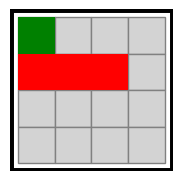

To a state incorporating the following block position(s):


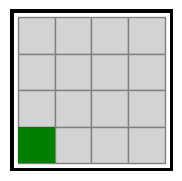


** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=None
Max search nodes: 10000000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 4
Goal state is:


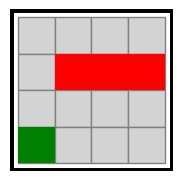

The action path to the solution is:
('red', 'right')
('green', 'down')
('green', 'down')
('green', 'down')

The state/action path to the solution is:


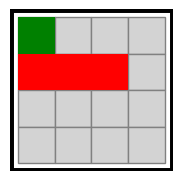

('red', 'right')


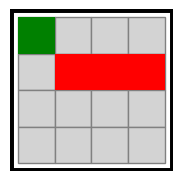

('green', 'down')


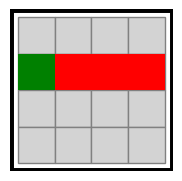

('green', 'down')


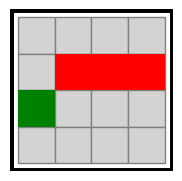

('green', 'down')


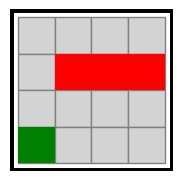


SEARCH SPACE STATS:
Total nodes generated          =      157  (includes start)
Nodes discarded by loop_check  =      100  (57 distinct states added to queue)
Nodes tested (by goal_test)    =       35  (34 expanded + 1 goal)
Nodes left in queue            =       22

Time taken = 0.0908 seconds



In [11]:
move_red_search = search( traverse_red_puzzle, 'BF/FIFO', 10000000, loop_check=True, randomise=False, show_state_path=True, return_info=True)

Solve the following sliding blocks problem.
Get from this initial state:


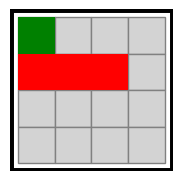

To a state incorporating the following block position(s):


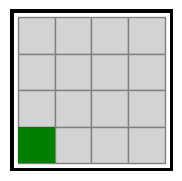


** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=weighted_cost, heuristic=None
Max search nodes: 10000000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 9
Goal state is:


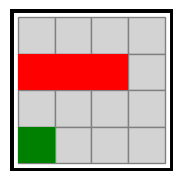

Cost of reaching goal: 9
The action path to the solution is:
('green', 'right')
('green', 'right')
('green', 'right')
('green', 'down')
('green', 'down')
('green', 'left')
('green', 'left')
('green', 'down')
('green', 'left')

The state/action path to the solution is:


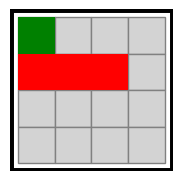

('green', 'right')


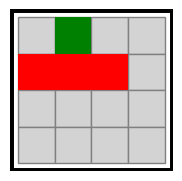

('green', 'right')


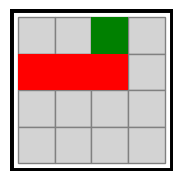

('green', 'right')


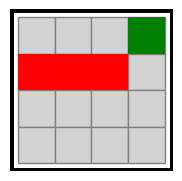

('green', 'down')


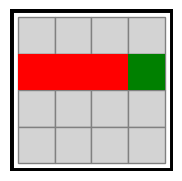

('green', 'down')


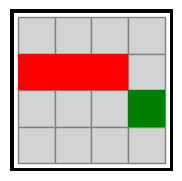

('green', 'left')


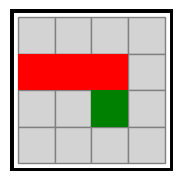

('green', 'left')


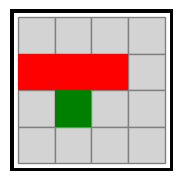

('green', 'down')


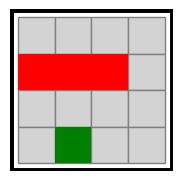

('green', 'left')


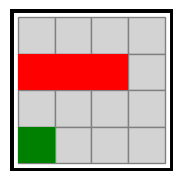


SEARCH SPACE STATS:
Total nodes generated          =       76  (includes start)
Nodes discarded by loop_check  =       25  (51 distinct states added to queue)
Nodes tested (by goal_test)    =       17  (16 expanded + 1 goal)
Nodes left in queue            =       34

Time taken = 0.2032 seconds



In [10]:
around_red_search = search( traverse_red_puzzle, 'DF/LIFO', 10000000, loop_check=True, randomise=False, show_state_path=True, cost = traverse_red_puzzle.weighted_cost, return_info=True)

Solve the following sliding blocks problem.
Get from this initial state:


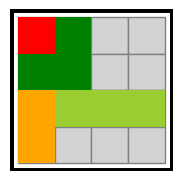

To a state incorporating the following block position(s):


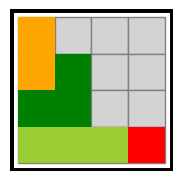


** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=None
Max search nodes: 10000000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 13
Goal state is:


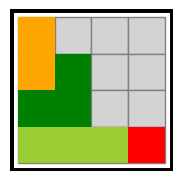

The action path to the solution is:
('green', 'right')
('red', 'right')
('yellowgreen', 'down')
('green', 'down')
('red', 'right')
('red', 'right')
('red', 'down')
('red', 'down')
('orange', 'up')
('yellowgreen', 'left')
('red', 'down')
('orange', 'up')
('green', 'left')

The state/action path to the solution is:


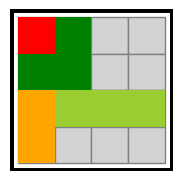

('green', 'right')


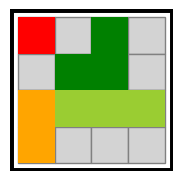

('red', 'right')


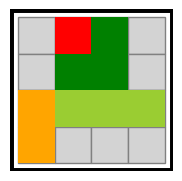

('yellowgreen', 'down')


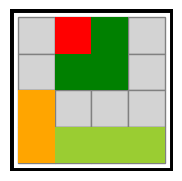

('green', 'down')


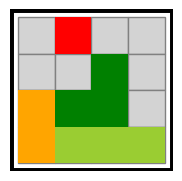

('red', 'right')


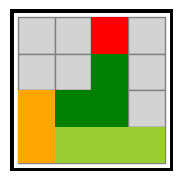

('red', 'right')


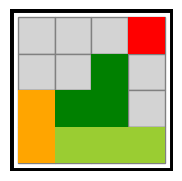

('red', 'down')


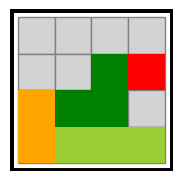

('red', 'down')


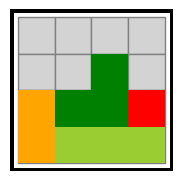

('orange', 'up')


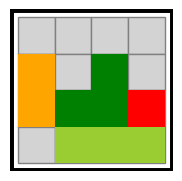

('yellowgreen', 'left')


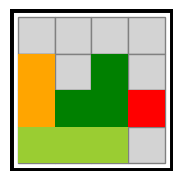

('red', 'down')


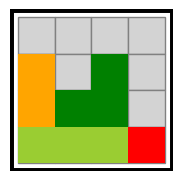

('orange', 'up')


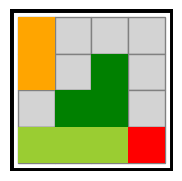

('green', 'left')


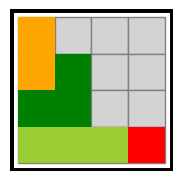


SEARCH SPACE STATS:
Total nodes generated          =     1720  (includes start)
Nodes discarded by loop_check  =     1362  (358 distinct states added to queue)
Nodes tested (by goal_test)    =      344  (343 expanded + 1 goal)
Nodes left in queue            =       14

Time taken = 0.2438 seconds



In [14]:
normal_search = search( normal_puzzle, 'BF/FIFO', 10000000, loop_check=True,randomise=False, show_state_path=True, return_info=True)

Solve the following sliding blocks problem.
Get from this initial state:


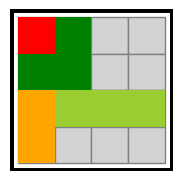

To a state incorporating the following block position(s):


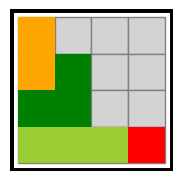


** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=correct_positions_heuristic
Max search nodes: 10000000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 13
Goal state is:


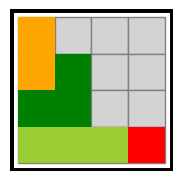

The action path to the solution is:
('green', 'right')
('orange', 'up')
('red', 'right')
('orange', 'up')
('yellowgreen', 'left')
('yellowgreen', 'down')
('green', 'down')
('red', 'right')
('red', 'right')
('red', 'down')
('red', 'down')
('red', 'down')
('green', 'left')

The state/action path to the solution is:


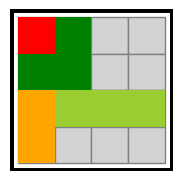

('green', 'right')


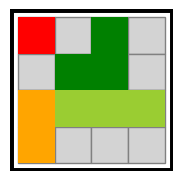

('orange', 'up')


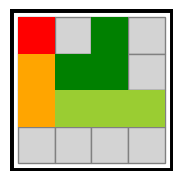

('red', 'right')


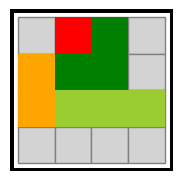

('orange', 'up')


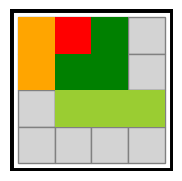

('yellowgreen', 'left')


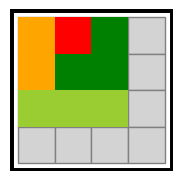

('yellowgreen', 'down')


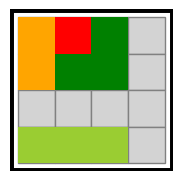

('green', 'down')


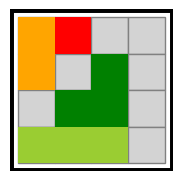

('red', 'right')


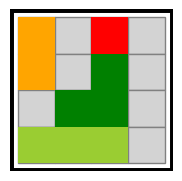

('red', 'right')


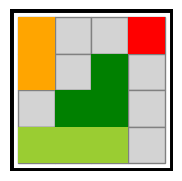

('red', 'down')


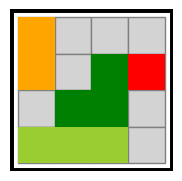

('red', 'down')


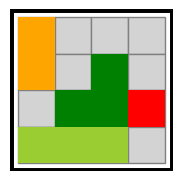

('red', 'down')


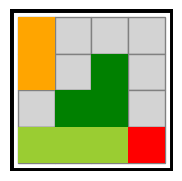

('green', 'left')


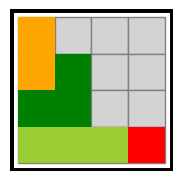


SEARCH SPACE STATS:
Total nodes generated          =      738  (includes start)
Nodes discarded by loop_check  =      449  (289 distinct states added to queue)
Nodes tested (by goal_test)    =      144  (143 expanded + 1 goal)
Nodes left in queue            =      145

Time taken = 0.2397 seconds



In [15]:
correct_positions_search = search( normal_puzzle, 'BF/FIFO', 10000000, loop_check=True,randomise=False, show_state_path=True, return_info=True, heuristic = correct_positions_heuristic )

Solve the following sliding blocks problem.
Get from this initial state:


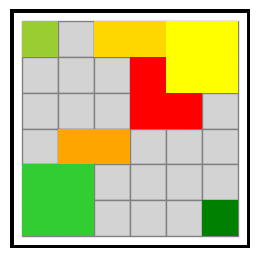

To a state incorporating the following block position(s):


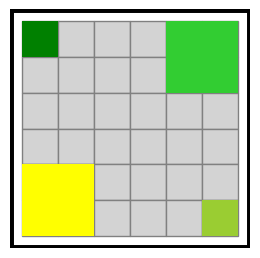


** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=None
Max search nodes: 10000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
...
!! Search node limit (10000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =    43459  (includes start)
Nodes discarded by loop_check  =    33458  (10001 distinct states added to queue)
Nodes tested (by goal_test)    =     3423  (all expanded)
Nodes left in queue            =     6577

Time taken = 0.7514 seconds



In [17]:
four_corners_search = search( four_corners_puzzle, 'BF/FIFO', 10000, loop_check=True, randomise=False, show_state_path=True, return_info=True)

Solve the following sliding blocks problem.
Get from this initial state:


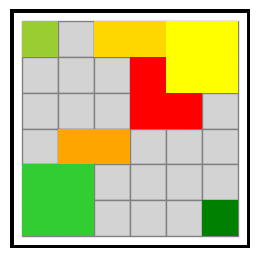

To a state incorporating the following block position(s):


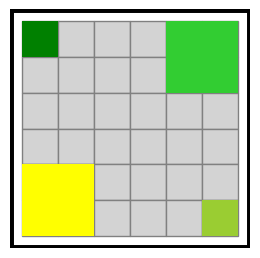


** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=four_corners_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 52
Goal state is:


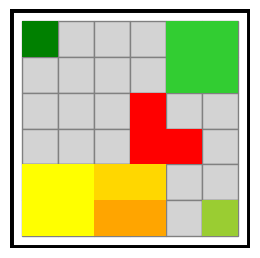

The action path to the solution is:
('green', 'left')
('green', 'left')
('green', 'left')
('green', 'up')
('yellowgreen', 'right')
('yellowgreen', 'down')
('yellowgreen', 'right')
('orange', 'left')
('green', 'up')
('green', 'up')
('green', 'left')
('green', 'left')
('green', 'up')
('green', 'up')
('limegreen', 'right')
('limegreen', 'right')
('limegreen', 'right')
('limegreen', 'right')
('limegreen', 'up')
('yellowgreen', 'down')
('yellowgreen', 'down')
('yellowgreen', 'right')
('red', 'left')
('limegreen', 'up')
('yellowgreen', 'down')
('yellowgreen', 'right')
('yellowgreen', 'right')
('gold', 'left')
('yellow', 'left')
('red', 'down')
('gold', 'down')
('gold', 'left')
('yellow', 'left')
('limegreen', 'up')
('limegreen', 'up')
('gold', 'down')
('yellow', 'left')
('orange', 'down')
('gold', 'down')
('red', 'right')
('yellow', 'down')
('yellow', 'left')
('orange', 'down')
('gold', 'down')
('yellow', 'down')
('gold', 'right')
('gold', 'right')
('yellow', 'down')
('orange', 'right')
('or

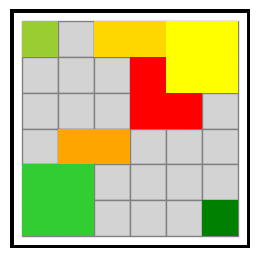

('green', 'left')


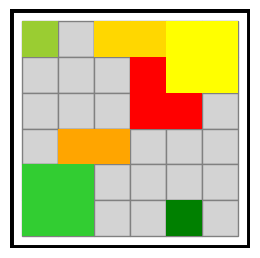

('green', 'left')


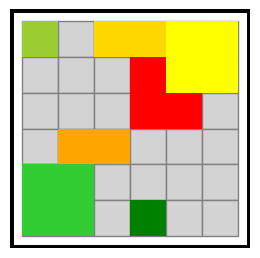

('green', 'left')


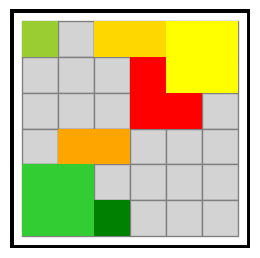

('green', 'up')


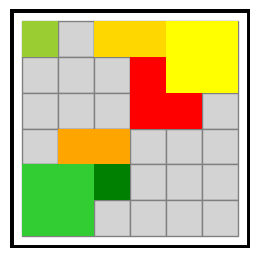

('yellowgreen', 'right')


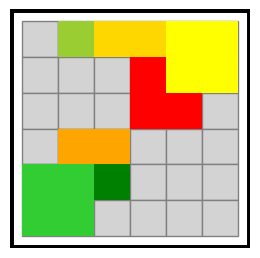

('yellowgreen', 'down')


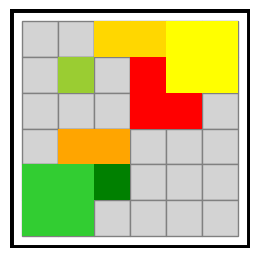

('yellowgreen', 'right')


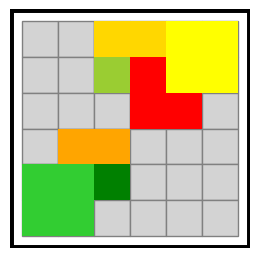

('orange', 'left')


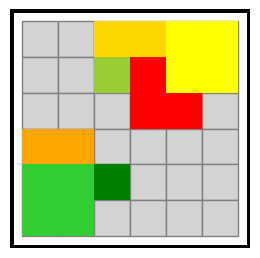

('green', 'up')


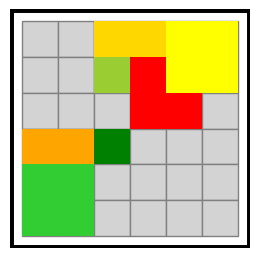

('green', 'up')


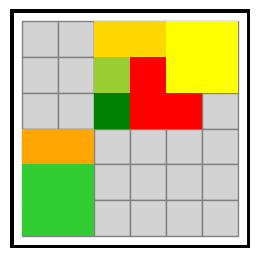

('green', 'left')


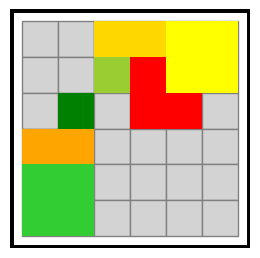

('green', 'left')


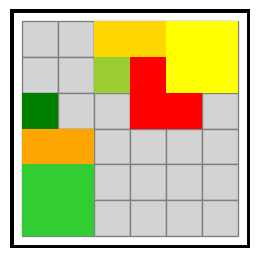

('green', 'up')


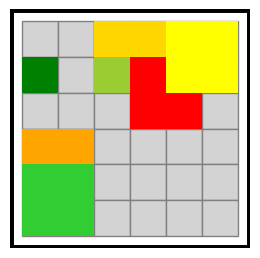

('green', 'up')


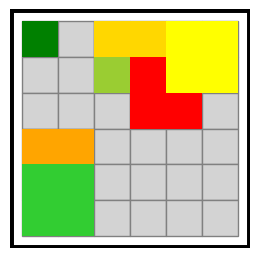

('limegreen', 'right')


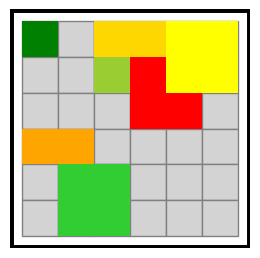

('limegreen', 'right')


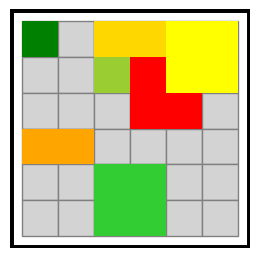

('limegreen', 'right')


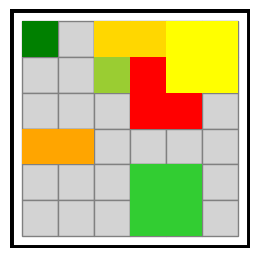

('limegreen', 'right')


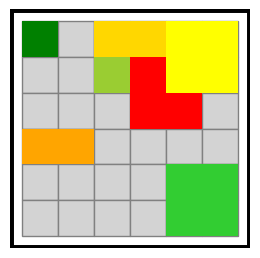

('limegreen', 'up')


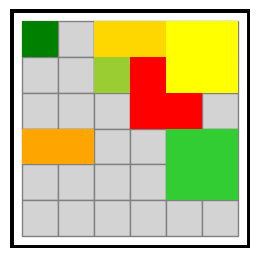

('yellowgreen', 'down')


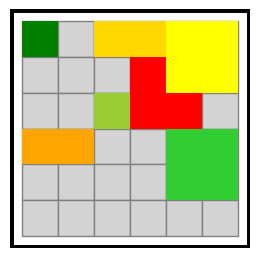

('yellowgreen', 'down')


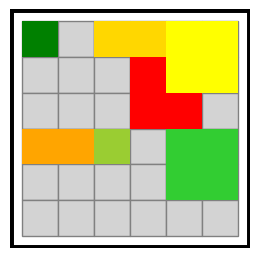

('yellowgreen', 'right')


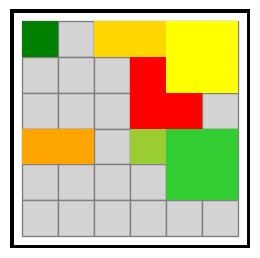

('red', 'left')


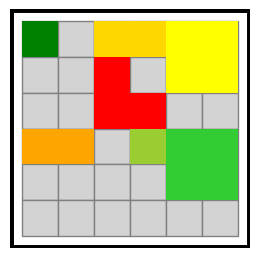

('limegreen', 'up')


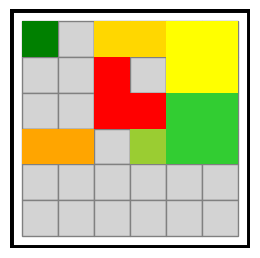

('yellowgreen', 'down')


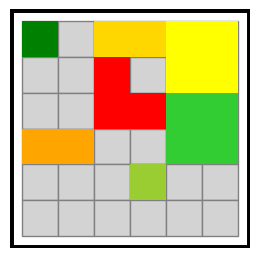

('yellowgreen', 'right')


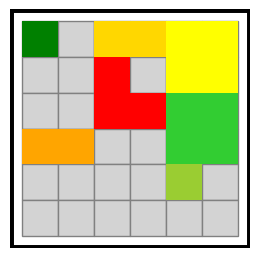

('yellowgreen', 'right')


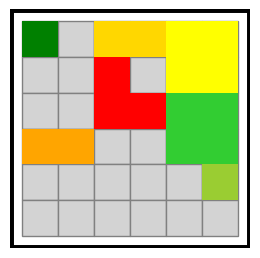

('gold', 'left')


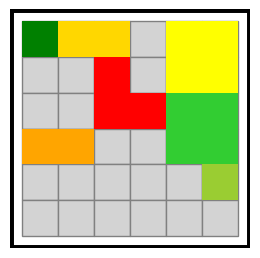

('yellow', 'left')


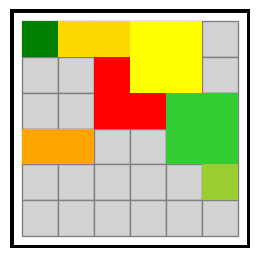

('red', 'down')


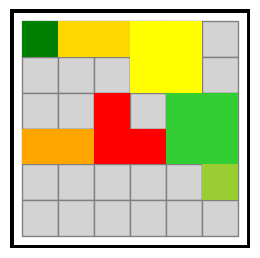

('gold', 'down')


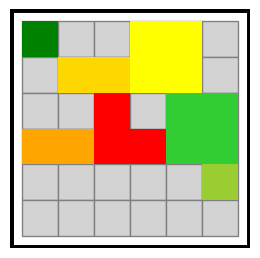

('gold', 'left')


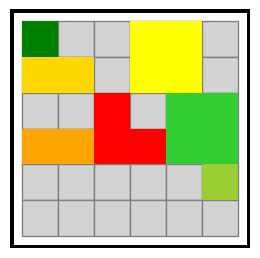

('yellow', 'left')


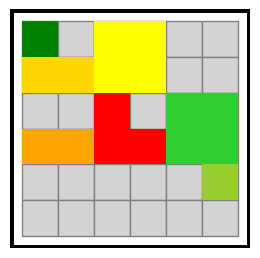

('limegreen', 'up')


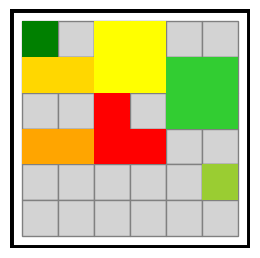

('limegreen', 'up')


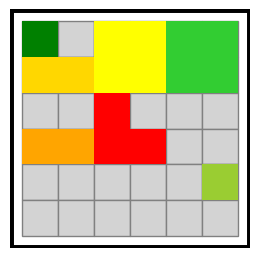

('gold', 'down')


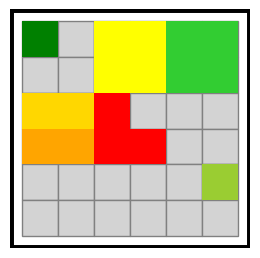

('yellow', 'left')


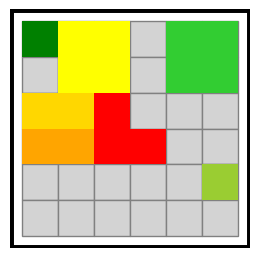

('orange', 'down')


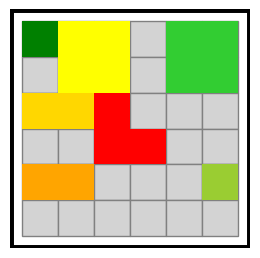

('gold', 'down')


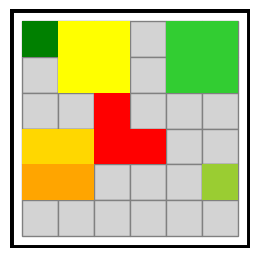

('red', 'right')


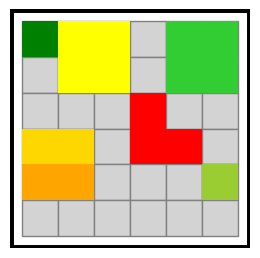

('yellow', 'down')


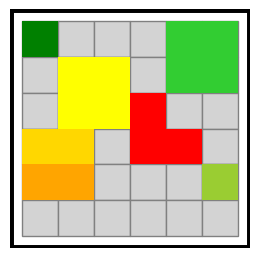

('yellow', 'left')


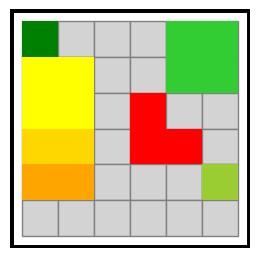

('orange', 'down')


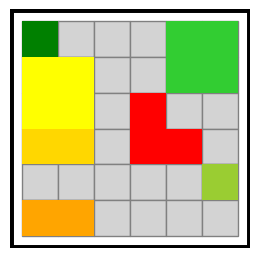

('gold', 'down')


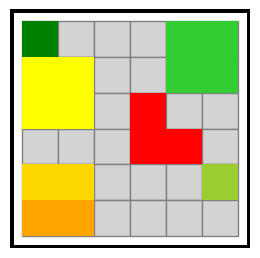

('yellow', 'down')


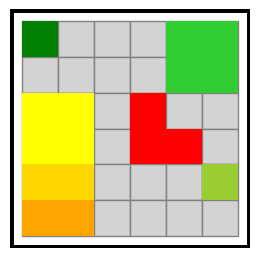

('gold', 'right')


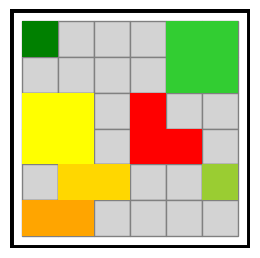

('gold', 'right')


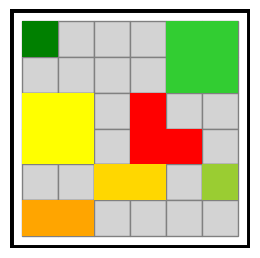

('yellow', 'down')


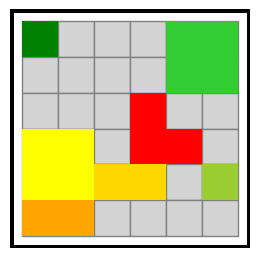

('orange', 'right')


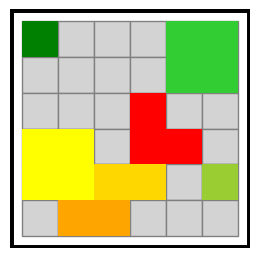

('orange', 'right')


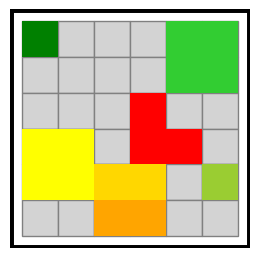

('yellow', 'down')


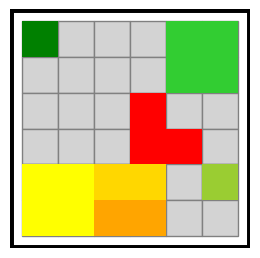

('yellowgreen', 'down')


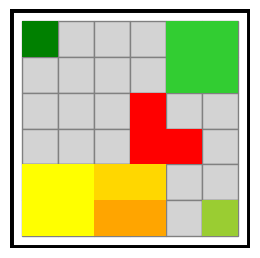


SEARCH SPACE STATS:
Total nodes generated          =     2783  (includes start)
Nodes discarded by loop_check  =      958  (1825 distinct states added to queue)
Nodes tested (by goal_test)    =      245  (244 expanded + 1 goal)
Nodes left in queue            =     1580

Time taken = 1.4674 seconds



In [18]:
heuristic_four_corners_search = search( four_corners_puzzle, 'BF/FIFO', 100000, loop_check=True, randomise=False, show_state_path=True, return_info=True, heuristic = four_corners_heuristic)

In [19]:
TEST_RESULTS =[ move_red_search, around_red_search, normal_search, four_corners_search, heuristic_four_corners_search ]

# Specify symbols for termination conditions:
short_tc = {"GOAL_STATE_FOUND"     : "Y",
            "NODE_LIMIT_EXCEEDED"  : "!",
            "SEARH-SPACE_EXHAUSTED": "x"}

print("\n                **TESTS SUMMARY**\n")

print("Test    #max   Result   #gen     #inQ    Time s")
for i, test in enumerate(TEST_RESULTS):
    max  = test['args']['max_nodes']
    tc  = test['result']['termination_condition']
    stc = short_tc[tc]

    ng  = test['search_stats']['nodes_generated']
    nq  = test['search_stats']['nodes_left_in_queue']
    time = round( test['search_stats']['time_taken'], 2 )
    print( f"{i:>3}: {max:>8}    {stc}  {ng:>8} {nq:>8}     {time} ")


                **TESTS SUMMARY**

Test    #max   Result   #gen     #inQ    Time s
  0: 10000000    Y       157       22     0.09 
  1: 10000000    Y        76       34     0.2 
  2: 10000000    Y      1720       14     0.24 
  3:    10000    !     43459     6577     0.75 
  4:   100000    Y      2783     1580     1.47 
